<a href="https://colab.research.google.com/github/juliaokmenezes/juliaokmenezes.github.io/blob/main/Analysis_NuTBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**INTRODUÇÃO**


O objetivo desse notebook é analisar o desempenho da aplicação nutbox quando submetida a testes de estresse.

Para realizar o estresse foi utilizado a feramenta Jmeter, que sujeitou a aplicação ao envio de arquivos com tamanhos crescentes.
## *Versões*
Foram utilizados duas versões para realização dos testes:
*   1.0.0: NuTBox com armazenamento em volume local.
*   1.1.0: NuTBox com armazenamento na S3 da AWS.

## *Variáveis*
E as variáveis a serem analisadas são:
*   Uso de CPU
*   Uso de memória
*   Percentual de requisições falhas
*   Latência

##*Rotas*
Foram realizadas requisições nos seguintes endopoints da aplicação:
*   /upload
*   /download/:id
*   download e upload concorrentemente.

###**IMPORTS**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from datetime import datetime
import numpy as np

###**LEITURA DOS CSV COM OS DADOS**

In [3]:
LSC_4MB = pd.read_csv(f"https://drive.google.com/uc?id=1UtCdNbPP7puLaVov4hdQoJeqDlrJ6di6")
LSC_8MB = pd.read_csv(f"https://drive.google.com/uc?id=1C7HxJsJYIIwc8p7HDjG7DMk4-EiHzx9Y")
LSC_16MB = pd.read_csv(f"https://drive.google.com/uc?id=1UI7syE5j1hEqy9i2Gv6nptD2JY8ziapr")
LSC_32MB = pd.read_csv(f"https://drive.google.com/uc?id=1XnmDsTaDqV7hEKimQwGA5vAD4xEtqEIM")
LSC_64MB = pd.read_csv(f"https://drive.google.com/uc?id=1O2Vk3Io2EEiPodmKCNdJtqkCesRaaJLM")
LSC_128MB = pd.read_csv(f"https://drive.google.com/uc?id=1PmzoJbdlW9Lz9eWscG6n_9ATBdvHGb_0")
LSC_256MB = pd.read_csv(f"https://drive.google.com/uc?id=1LJSR0Z2ootZN_prec5v9qf_50kwG6BSA")

S3C_4MB = pd.read_csv(f"https://drive.google.com/uc?id=1cwvYzZKhP6bYy7Vpqf2SPj03fk9_kSDP")
S3C_8MB = pd.read_csv(f"https://drive.google.com/uc?id=1fytGkejLlVZBGfWCs-sD1FKm-wlm6-Wp")
S3C_16MB = pd.read_csv(f"https://drive.google.com/uc?id=1-CIPexS5JXZYUYMGHdhZH4PwiFqWmHF9")
S3C_32MB = pd.read_csv(f"https://drive.google.com/uc?id=1bViu_3-QbdlF5nuYptnXa1mxE4TB6D4a")
S3C_64MB = pd.read_csv(f"https://drive.google.com/uc?id=1JXViTgBW3r_4gMTZD_vwwKUej_RA8ouk")
S3C_128MB = pd.read_csv(f"https://drive.google.com/uc?id=1m-X7p9IprTb4mtglHWRzK5KUfzXWhDhX")
S3C_256MB = pd.read_csv(f"https://drive.google.com/uc?id=1QtXR6LoD2AwRa0J19fm4sjH7bsB3Jr_M")


LSS_4MB = pd.read_csv(f"https://drive.google.com/uc?id=1j5SbrrT7W2hGdnuor27_EE5C3iVnX7Fg")
LSS_8MB = pd.read_csv(f"https://drive.google.com/uc?id=1uAJyiamStq_dggpFJ2x1Awti9gojfAxr")
LSS_16MB = pd.read_csv(f"https://drive.google.com/uc?id=1N18DesSYxAHEVvJHBNibv3aGzrZhOizz")
LSS_32MB = pd.read_csv(f"https://drive.google.com/uc?id=1XlWjPR7ekkTY8NxieZI763vNV1X0rr1k")
LSS_64MB = pd.read_csv(f"https://drive.google.com/uc?id=1ahV5TxmIX4MUoNWbs8Lr_ozoAcMxIupj")
LSS_128MB = pd.read_csv(f"https://drive.google.com/uc?id=1C-QkM4zP2v7LG5yBMVA0bslAhqM25mdu")
LSS_256MB = pd.read_csv(f"https://drive.google.com/uc?id=1fe6dx7RVsupMYPALCaQepaVeNd4tv-Nf")

### **PRÉ PROCESSAMENTO DOS DADOS**

In [4]:
LSC = pd.concat([LSC_4MB, LSC_8MB, LSC_16MB, LSC_32MB, LSC_64MB, LSC_128MB, LSC_256MB], ignore_index=True)
LSS = pd.concat([LSS_4MB, LSS_8MB, LSS_16MB, LSS_32MB, LSS_64MB, LSS_128MB, LSS_256MB], ignore_index=True)
S3C = pd.concat([S3C_4MB, S3C_8MB, S3C_16MB, S3C_32MB, S3C_64MB, S3C_128MB, S3C_256MB], ignore_index=True)

LSC_UP = LSC.loc[LSC['operation'] == 'Upload']
LSC_DW = LSC.loc[LSC['operation'] == 'Download']
LSS_UP = LSS.loc[LSS['operation'] == 'Upload']
LSS_DW = LSS.loc[LSS['operation'] == 'Download']
S3C_UP = S3C.loc[S3C['operation'] == 'Upload']
S3C_DW = S3C.loc[S3C['operation'] == 'Download']
LSs = [LSC_UP, LSC_DW, LSS_UP, LSS_DW]

# def parse_timestamp(date):
#   formats = ["%Y/%m/%d %H:%M:%S", "%Y-%m-%d %H:%M:%S:%f"]

#   for format in formats:
#     try:
#       date_obj = datetime.strptime(date, format)
#       timestamp = date_obj.timestamp()
#       return timestamp
#     except ValueError:
#       pass

# for df in LSs:
#   init_time = parse_timestamp(df.iloc[0]['timeStamp'])
#   print(init_time)
#   df['Time Elapsed'] = df['timeStamp'].apply(lambda date: parse_timestamp(date) - init_time)

### **Análise dos Resultados**

O que é necessário fazer:


*   Trocar o link para os novos testes
*   Diminuir quantidade de tamanhos de arquivos
*   Realizar novos testes
*   Realizar analises
*   visão de outlier
*   plotar u gráfico o contrario do ecdfc(dois desvios padrões ou interquartil)



[Text(0.5, 1.0, 'Latência em Upload Local Storage'),
 Text(0.5, 0, 'Proporção'),
 Text(0, 0.5, 'Latencia (Ms)')]

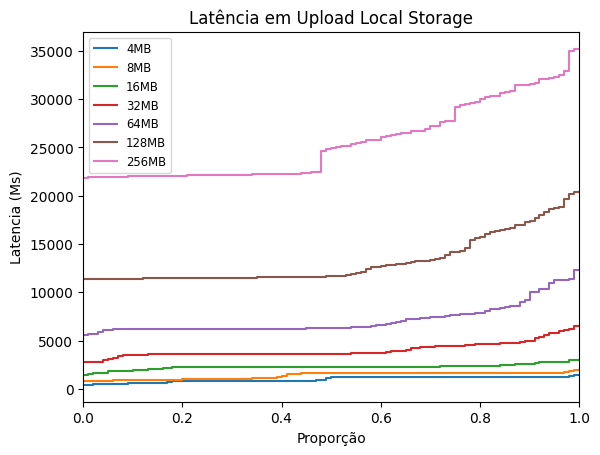

In [5]:
ax = sns.ecdfplot(data=LSC_4MB, y='elapsed', label='4MB')
ax = sns.ecdfplot(data=LSC_8MB, y='elapsed', label='8MB')
ax = sns.ecdfplot(data=LSC_16MB, y='elapsed', label='16MB')
ax = sns.ecdfplot(data=LSC_32MB, y='elapsed', label='32MB')
ax = sns.ecdfplot(data=LSC_64MB, y='elapsed', label='64MB')
ax = sns.ecdfplot(data=LSC_128MB,y='elapsed', label='128MB')
ax = sns.ecdfplot(data=LSC_256MB,y='elapsed', label='256MB')
plt.legend(loc='upper left', fontsize='small')
ax.set(title ="Latência em Upload Local Storage", xlabel='Proporção', ylabel='Latencia (Ms)')

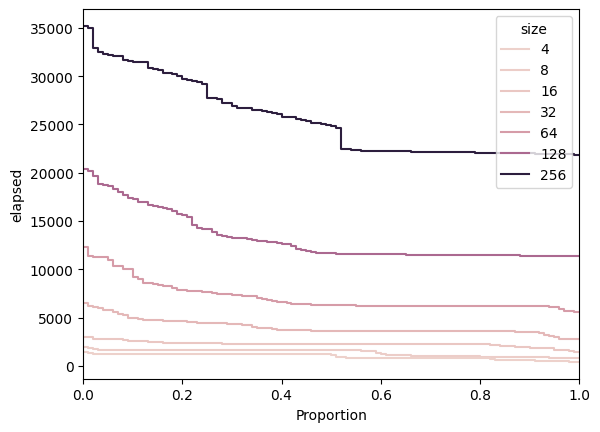

In [32]:
ax = sns.ecdfplot(data=LSC, y='elapsed', hue='size',complementary=True)

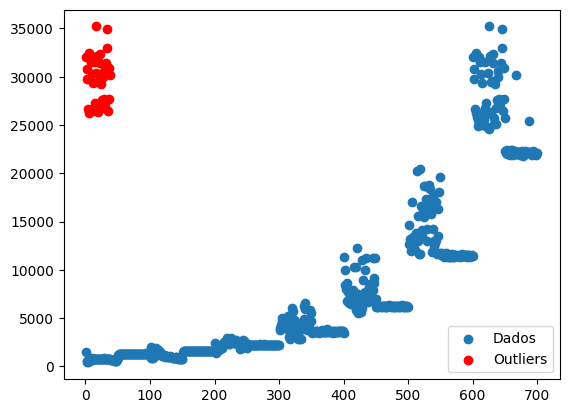

In [33]:
dados = LSC['elapsed']

q1 = np.percentile(dados, 25)
q3 = np.percentile(dados, 75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = [x for x in dados if x < limite_inferior or x > limite_superior]

plt.scatter(range(1, len(dados) + 1), dados, label='Dados')

plt.scatter(range(1, len(outliers) + 1), outliers, color='red', label='Outliers')

plt.legend()
plt.show()

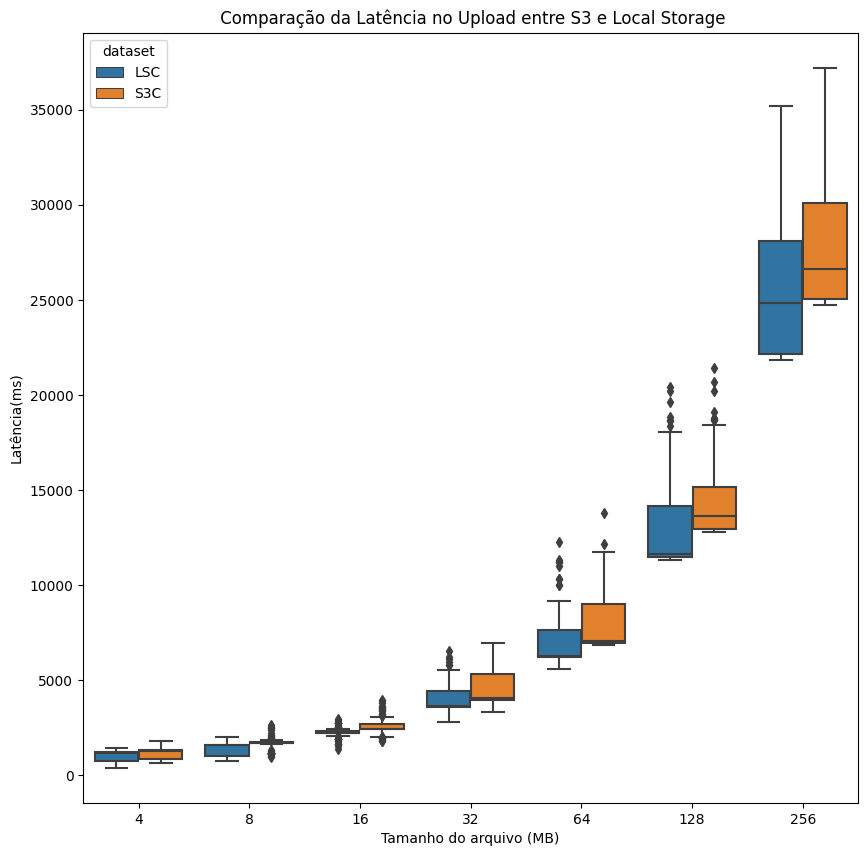

In [7]:
LSC['dataset'] = 'LSC'
S3C['dataset'] = 'S3C'
combined_data = pd.concat([LSC, S3C])
plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=combined_data, x='size', y='elapsed', hue='dataset')
ax.set(title =" Comparação da Latência no Upload entre S3 e Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Latência(ms)')

plt.show()

[Text(0.5, 1.0, 'Uso de RAM em Upload do Local Storage'),
 Text(0.5, 0, 'Tamanho do arquivo (MB)'),
 Text(0, 0.5, 'Uso de RAM(%)')]

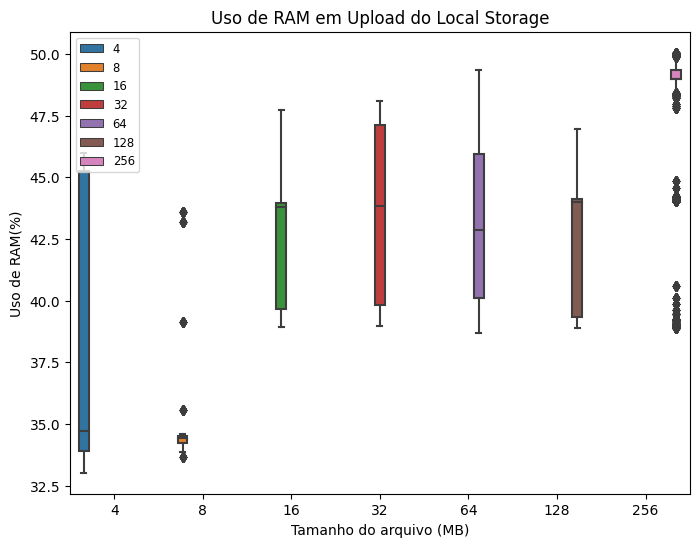

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=LSS, x='size', y='raw_usage', hue='size')
plt.legend(loc='upper left', fontsize='small')
ax.set(title ="Uso de RAM em Upload do Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Uso de RAM(%)')

[Text(0.5, 1.0, 'Latência em Upload Local Storage')]

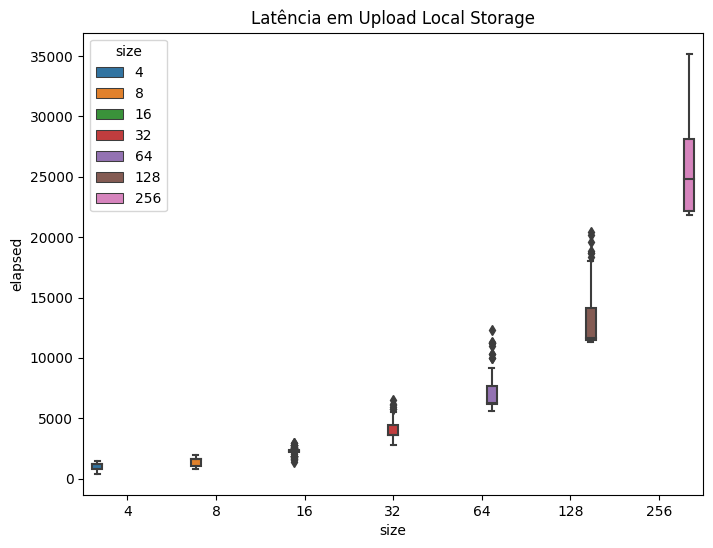

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=LSC, x='size', y='elapsed', hue='size')
ax.set(title ="Latência em Upload Local Storage")

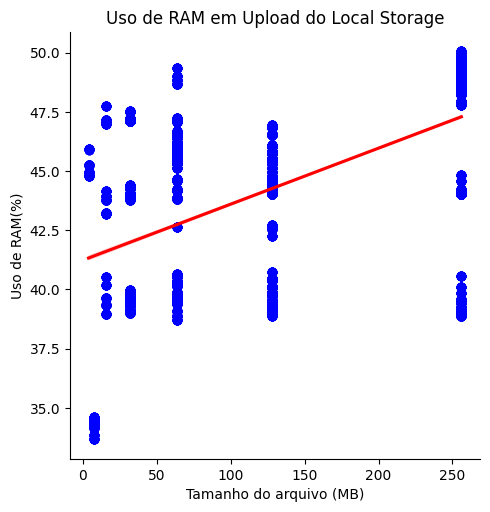

In [10]:
my_palette = ["red", "blue"]
ax = sns.lmplot(data=LSS_UP, x='size', y='raw_usage',
           scatter_kws={"color": my_palette[1]}, line_kws={"color": my_palette[0]})
ax.set(title ="Uso de RAM em Upload do Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Uso de RAM(%)')

[Text(0.5, 1.0, 'Uso de RAM em Upload Local Storage'),
 Text(0.5, 0, 'Proporção'),
 Text(0, 0.5, 'Uso de RAM(%)')]

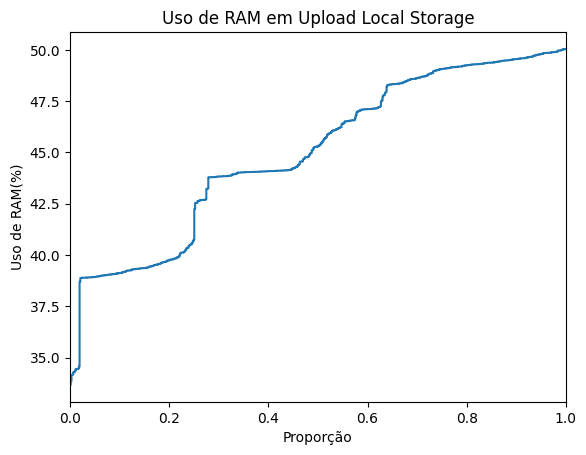

In [11]:
ax = sns.ecdfplot(data=LSS_UP,y='raw_usage')
ax.set(title ="Uso de RAM em Upload Local Storage", xlabel='Proporção', ylabel='Uso de RAM(%)')

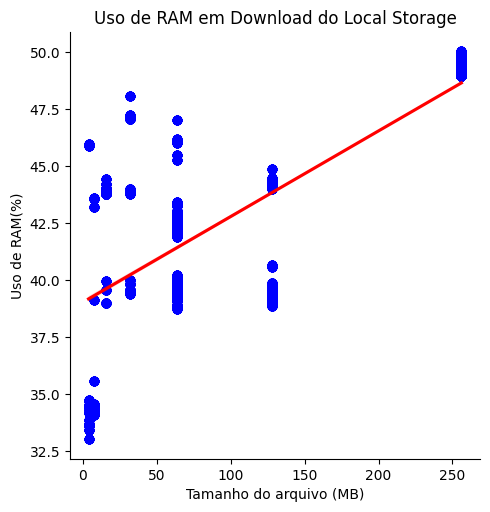

In [12]:
my_palette = ["red", "blue"]
ax = sns.lmplot(data=LSS_DW, x='size', y='raw_usage',
           scatter_kws={"color": my_palette[1]}, line_kws={"color": my_palette[0]})
ax.set(title ="Uso de RAM em Download do Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Uso de RAM(%)')

[Text(0.5, 1.0, 'Uso de RAM em Download Local Storage'),
 Text(0.5, 0, 'Proporção'),
 Text(0, 0.5, 'Uso de RAM(%)')]

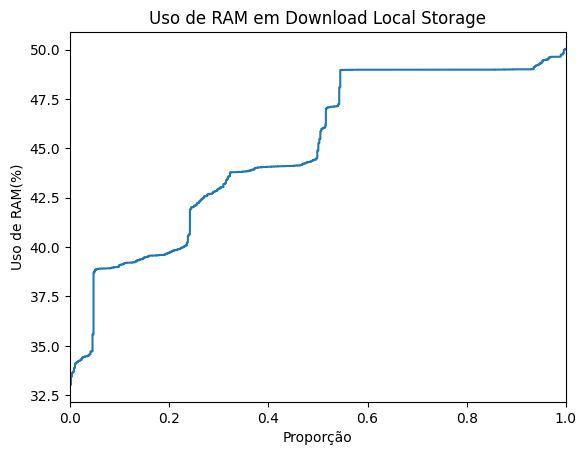

In [13]:
ax = sns.ecdfplot(data=LSS_DW,y='raw_usage')
ax.set(title ="Uso de RAM em Download Local Storage", xlabel='Proporção', ylabel='Uso de RAM(%)')

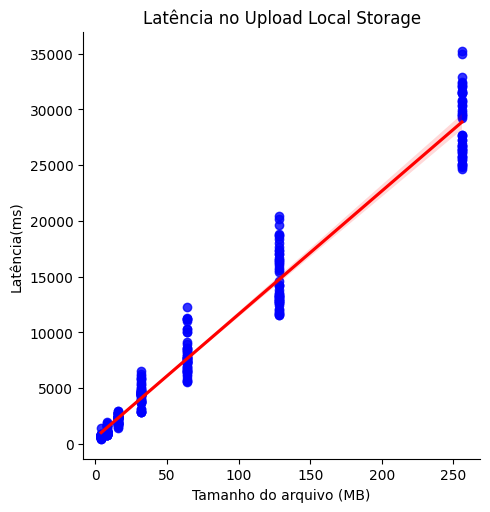

In [14]:
my_palette = ["red", "blue"]
ax = sns.lmplot(data=LSC_UP, x='size', y='elapsed',
           scatter_kws={"color": my_palette[1]}, line_kws={"color": my_palette[0]})
ax.set(title ="Latência no Upload Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Latência(ms)')


[Text(0.5, 1.0, 'Latência no Upload Local Storage'),
 Text(0.5, 0, 'Proporção'),
 Text(0, 0.5, 'Latência(ms)')]

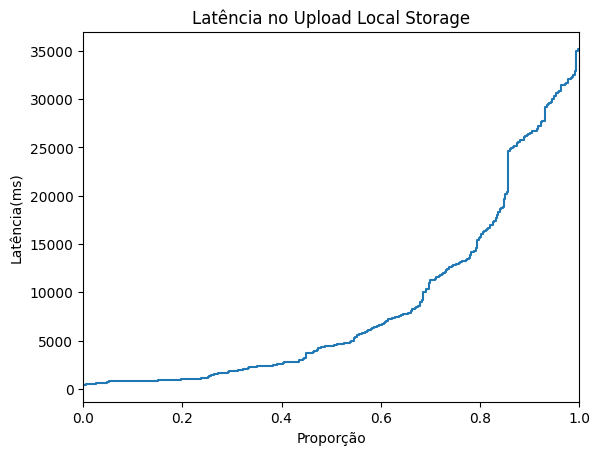

In [15]:
ax = sns.ecdfplot(data=LSC_UP,y='elapsed')
ax.set(title ="Latência no Upload Local Storage", xlabel='Proporção', ylabel='Latência(ms)')

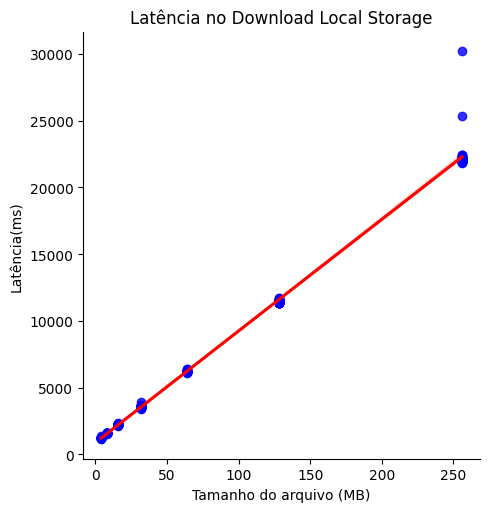

In [16]:
my_palette = ["red", "blue"]
ax = sns.lmplot(data=LSC_DW, x='size', y='elapsed',
           scatter_kws={"color": my_palette[1]}, line_kws={"color": my_palette[0]})

ax.set(title ="Latência no Download Local Storage", xlabel='Tamanho do arquivo (MB)', ylabel='Latência(ms)')


[Text(0.5, 1.0, 'Latência no Download Local Storage'),
 Text(0.5, 0, 'Proporção'),
 Text(0, 0.5, 'Latência(ms)')]

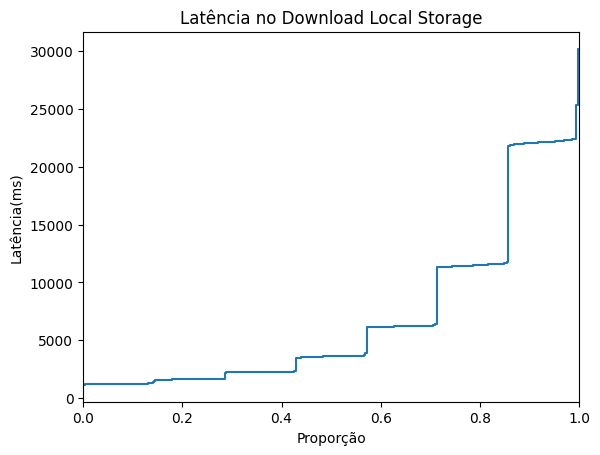

In [17]:
ax = sns.ecdfplot(data=LSC_DW,y='elapsed')
ax.set(title ="Latência no Download Local Storage", xlabel='Proporção', ylabel='Latência(ms)')